In [19]:
import pandas as pd
import numpy as np
import os
import math
from copy import copy
import datetime
import warnings

In [ ]:
!pip install ipython-autotime
%load_ext autotime

# StillingerWeber class

In [20]:
class StillingerWeber:
    """
        Class for calculating SW potential for silicon and fullerene, 
        optimization params of SW potential for fullerene
    """
    def __set_SW_params(self, struct_name='silicon') -> None:
        """
        Function sets default parameters for SW potential (for "silicon") or
        chooses optimized parameters suitable for fullerene.
            
            :param struct_name: "silicon" or "fullerene"
            
            :return None
        """
        if struct_name.lower() == 'silicon':
            self.eps = 2.16826
            self.A = 7.049556277
            self.B = 0.6022245584
            self.sigma = 2.0951
            self.p = 4
            self.a = 1.8
            self.LAMBDA = 21.0
            self.gamma = 1.2
            self.cos_theta0 = -1/3
            self.params = np.array([self.eps, self.A, self.B, self.sigma, self.p,
                                    self.a, self.LAMBDA, self.gamma, self.cos_theta0])
            
        elif struct_name.lower() == 'fullerene':
            self.eps = 2.16376271 
            self.A = 7.05471636
            self.B = 0.21584245
            self.sigma = 1.70666882
            self.p = 3.9651871
            self.a = 1.67952818
            self.LAMBDA = 20.997803 
            self.gamma = 1.36300948
            self.cos_theta0 = -0.26969633
            self.params = np.array([self.eps, self.A, self.B, self.sigma, self.p,
                                    self.a, self.LAMBDA, self.gamma, self.cos_theta0])
        
        else: 
            raise ValueError('Please choose option between "silicon" and "fullerene"')
            
    @staticmethod
    def theta_func(x) -> int:
        """
        Math Heaviside function
        """
        if x > 0:
            return 1
        else:
            return 0

    @staticmethod
    def delta_func(x) -> int:
        """
        Math delta function
        """
        if x == 0:
            return 1
        else:
            return 0

    @staticmethod
    def cos_3d(vec1, vec2) -> float:
        """
        Function calc cos() between two 3-dimensional vectors
        """
        scalar_product = np.dot(vec1, vec2)
        mod1 = np.linalg.norm(vec1)
        mod2 = np.linalg.norm(vec2)
        if mod1 == 0 or mod2 == 0:
            raise ZeroDivisionError('One of vectors is equal to zero vector')
        else:
            return scalar_product/(mod1*mod2)
        
    def calc_pot_per_atom(self, struct:np.array, atom_num:int) -> float:
        """
        Function calculates Stillinger-Weber potential for atom with number atom_num
        
            :param struct: np.array with shape (N_atoms, 3) with coordinates
            :param atom_num: atom number
            :return: float value of potential
        """
        res = 0
        for j in range(len(struct)):
            if j != atom_num:
                vec_ij = struct[j] - struct[atom_num]
                dist_ij = np.linalg.norm(vec_ij)
                if self.sigma != 0:
                    theta_ij = self.theta_func(self.a - dist_ij/self.sigma)
                else:
                    theta_ij = 0

                if theta_ij == 0:
                    prod = 0
                else:
                    exp_term_ij = self.gamma/(dist_ij/self.sigma - self.a)

                    # Calculating 2_body part
                    multiplicand = self.B*pow(self.sigma/dist_ij, self.p) - 1
                    multiplier = math.exp(1/(dist_ij/self.sigma - self.a))
                    prod = multiplicand * multiplier
                    res += prod
                    prod_3 = 0
                    for k in range(len(struct)):
                        if k != atom_num and k != j:
                            # Calculating 3_body part
                            vec_ik = struct[k] - struct[atom_num]
                            dist_ik = np.linalg.norm(vec_ik)
                            theta_ik = self.theta_func(self.a - dist_ik/self.sigma)
                            if theta_ik == 0:
                                prod_3 = 0
                            else:
                                cos_jik = self.cos_3d(vec_ij, vec_ik)
                                cos_mult = pow(cos_jik - self.cos_theta0, 2)

                                exp_term_ik = self.gamma/(dist_ik/self.sigma - self.a)
                                exp_mult = math.exp(exp_term_ij + exp_term_ik)
                                prod_3 = exp_mult * cos_mult
                                res += (self.LAMBDA/self.A) * prod_3
        
        return 1/2 * self.eps * self.A * res

    def calc_pot(self, struct) -> float:
        """
        Function calculates summarized potential for all atoms of the struct
        
            :param struct: np.array with shape (N_atoms, 3) with coordinates
            :return: value of SW potential for the struct
        """
        res = 0
        for i in range(len(struct)):
            res += self.calc_pot_per_atom(atom_num=i, struct=struct)
        return res
    
    def __change_consts(self, shift_vec=None,  how='shift'):
        """
        Function shift params of SW potential of assign new values to them
        
            :param shift_vec: vector for changing values in SW potential
            :param how: "assign" - set new values, or "shift" - change old values 
        """
        shift_vec = copy(shift_vec)
        if how == 'assign':
            self.params = shift_vec
            self.eps = shift_vec[0]
            self.A = shift_vec[1]
            self.B = shift_vec[2]
            self.sigma = shift_vec[3]
            self.p = shift_vec[4]
            self.a = shift_vec[5]
            self.LAMBDA = shift_vec[6]
            self.gamma = shift_vec[7]
            self.cos_theta0 = shift_vec[8]
        elif how == 'shift':
            self.params += shift_vec
            self.eps = self.params[0]
            self.A = self.params[1]
            self.B = self.params[2]
            self.sigma = self.params[3]
            self.p = self.params[4]
            self.a = self.params[5]
            self.LAMBDA = self.params[6]
            self.gamma = self.params[7]
            self.cos_theta0 = self.params[8]    
    
    def mse_loss(self, X, y):
        """
        Function calculate MSE loss between y_true (y) and y_pred = sw.calc_pot(X)
        
            :param X: vector of coords of atoms with shape (N_atoms, 3)
            :param y: true value of potential
        """
        def squared_error(struct, y_true):
            sw_pot = self.calc_pot(struct)
            return pow(sw_pot - y_true, 2)

        loss = 0
        for i in range(len(X)):
            loss += squared_error(X[i], y[i])

        mse = loss/len(X)
        return mse
    
    def optimize_params_for_fullerene(self, X=None, y=None, dir_path=None,
                                      EPS=5e-11, alpha=1e-7, iterations=1000,
                                      TOL=1e3):
        """
        Function of optimization existing parameters of SW potential based 
        on provided X and y (or files from dir_path if specified)
        
            :param X: vector of coords of atoms with shape (N_atoms, 3)
            :param y: true value of potential
            :param dir_path: directory path with files with coordinates of 
                Fullerene and values of energy (given from GAMESS software).
                If this param is specified, X and y shouldn't be specified
            :param EPS: tolerance of numerical calculation of derivative
            :param alpha: coefficient of proportional in expression 
                w_i+1 = w_i - alpha*grad(LossFunc); - gradient decent
            :param iterations: number of iterations of algorithm
            :param TOL: Max value of gradient of Loss Function. If gradient is
                lower then algorithm will stop earlier than moment when all 
                iterations will have be completed
        """
        
        # Case when need to download data from folder
        if dir_path is not None:
            X = []
            y = []
            for file in os.listdir(dir_path):
                try:
                    fln = Fullerene(filepath=dir_path + file, file_from='gamess_out_file',
                               struct_type='numpy')
                except NameError:
                    print('"Fullerene class have to be initialized!"')
                X += [fln.struct]
                y += [fln.energy]

        param_vec = copy(self.params)
        
        time_start = datetime.datetime.now()
        
        it = 0
        grad_value = TOL + 1
        while it < iterations and grad_value > TOL:
            time_start_it = datetime.datetime.now()
            print('\nITERATION: ', it)
            grad_vec = np.array([0 for k in range(len(param_vec))], dtype='float')
            for i in range(len(param_vec)):
                shift_vec = np.array([0 for k in range(len(param_vec))], dtype='float')
                shift_vec[i] = EPS
                self.__change_consts(shift_vec=shift_vec, how='shift')
                loss_plus = self.mse_loss(X, y)
                shift_vec[i] = -1*EPS
                self.__change_consts(shift_vec=2*shift_vec, how='shift')
                loss_minus = self.mse_loss(X, y)
                self.__change_consts(shift_vec=param_vec, how='assign')
                grad_vec[i] = (loss_plus-loss_minus)/(2*EPS)
            grad_value = np.linalg.norm(grad_vec)
            
            print('GRADIENT: ', grad_value)
            print('PARAMS VECTOR: ', self.params)
            
            self.__change_consts(shift_vec=grad_vec*(-1*alpha), how='shift')
            param_vec = copy(self.params)
            
            it += 1
            
            time_end_it = datetime.datetime.now()
            time_end = datetime.datetime.now()
            time_taken_it = round(((time_end_it - time_start_it).seconds*1e3  \
                                + (time_end_it - time_start_it).microseconds*1e-3)/1000, 3)
            
            print('TIME TAKEN: ', time_taken_it, 's')
            
        time_end = datetime.datetime.now()
        time_taken_gen = round(((time_end - time_start).seconds*1e3  \
                                + (time_end - time_start).microseconds*1e-3)/1000, 3)
        print('\nOVERALL TIME TAKEN: ', time_taken_gen)
        
    def __init__(self, struct_name='silicon'):
        self.__set_SW_params(struct_name)

# Atom class 

In [21]:
class Atoms:
    """
        Class with common methods for Fullerene and Silicon
    """
    def output_txt_coords(self, filename=None, show_atom_number=False) -> None:
        """
        Function save current struct coordinates to file with name filename.
        Format of data is suitable for Chemcraft visualisation.
        
            :param filename: name of file (As default saves to the
                'not_gamess_data/output_coords/atom_nameSTRUCTLENGTH.txt')
            :param show_atom_number: show atom number or show atom name

            :return: None
        """
        if filename is None:
            filename = 'not_gamess_data/output_coords/' + str(self.atom_name) \
                + str(self.length) + '.txt'
        
        if show_atom_number:
            atom = self.atom_num
        else:
            atom = self.atom_name
        data = pd.DataFrame({
            'Elem': [atom for i in range(self.length)],
            'x': self.struct.T[0],
            'y': self.struct.T[1],
            'z': self.struct.T[2]
        })
        data.to_csv(filename, index=False, sep='\t', header=False)
    
    def get_pd_coords(self, show_atom_number=False) -> pd.DataFrame:
        """
        Function returns coordinates in pandas format
        
            :param show_atom_number: show atom number or show atom name
            :return: pd.DataFrame
        """
        if show_atom_number:
            atom = self.atom_num
        else:
            atom = self.atom_name
        data = pd.DataFrame({
            'Elem': [atom for i in range(self.length)],
            'x': self.struct.T[0],
            'y': self.struct.T[1],
            'z': self.struct.T[2]
        })
        return data
    
    @staticmethod
    def __shift_atom(struct, atom, shift_vec=np.array([0,0,0], dtype='float')) -> np.array:
        """
        Method shift one atom of the struct by a shift_vec and returns new struct
        """
        struct = copy(struct)
        struct[atom] += shift_vec
        return struct

    def calc_force_per_atom(self, atom_num, EPS=1e-3) -> float:
        """
        Function calculates -1 * gradient of potential (force applied to the atom with number atom_num)
        Functions uses numerical method of calculation derivative
        
            :param atom_num: atom number
            :param eps: tolerance of calculating derivative
            :return: float value of force
        """
        grad = np.array([0, 0, 0], dtype='float')     # zero force vector
        
        # Shift for every axes
        for j in range(3):
            shift_vec = np.array([0,0,0], dtype='float')
            shift_vec[j] = EPS
            pot_plus_e = self.calc_pot_per_atom(
                struct = self.__shift_atom(struct=copy(self.struct),
                                           atom=atom_num, shift_vec=shift_vec),
                atom_num=atom_num)
            
            shift_vec[j] = -1*EPS
            
            pot_minus_e = self.calc_pot_per_atom(
                struct = self.__shift_atom(struct=copy(self.struct),
                                           atom=atom_num, shift_vec=shift_vec),
                atom_num=atom_num)
            
            grad += (pot_plus_e-pot_minus_e)/(2*EPS)
        return -1 * grad
    
    def __shift_struct(self, shift_vec):
        """
            Method shifts all struct by a shift_vec
        """
        self.struct += shift_vec
    
    def relax(self, iterations=100, start_alpha=5e-4, end_alpha=1e-5, TOL=1.5, max_shift=1e1, EPS=5e-8):
        """
        Function relax structure moving atoms along the forces. In general
        algorithm doing this: w_i+1 = w_i - alpha*grad(LossFunc); - gradient
        decent, but also It is allowed to decrease alpha along iterations. 
        Here used exponential attenuation by the rule alpha = C*exp(t*x), 
        where x is iteration.
        Specifying start_alpha and end_alpha determine C and t in this rule
            
            :param iterations: number of iterations of algorithm
            :param start_alpha:
            :param end_alpha:
            :param TOL: Max value of gradient of Loss Function. If gradient is
                lower then algorithm will stop earlier than moment when all 
                iterations will have be completed
            :param max_shift: max shift per iteration of atom can be restricted
            :param EPS: tolerance of numerical calculation of derivative
        """
        # Exp Cexp(tx)
        C = start_alpha
        t = 1/iterations * math.log(end_alpha/C)
        it = 0
        avg_force = TOL + 1
        while it < iterations and avg_force > TOL:
            shift_vec = []
            forces = []
            alpha = C*math.exp(t*it)
            print(f'Iteration: {it}, alpha: {alpha}')
            for atom in range(len(self.struct)):
                force = self.calc_force_per_atom(atom_num=atom, EPS=EPS)
                forces += [force]
                if np.linalg.norm(force) > TOL and np.linalg.norm(force) != 0:
                    shift_vec += [alpha * force]
                    for k in range(len(shift_vec[atom])):
                        if shift_vec[atom][k] > max_shift:
                            shift_vec[atom][k] = max_shift
                else:
                    shift_vec += [np.array([0,0,0], dtype='float')]
            avg_force = np.linalg.norm(np.array(forces), axis=1).mean()
            print('AVG Force Before step: ', avg_force)
            print()
            self.__shift_struct(np.array(shift_vec))
            it += 1

# DiamondStructure

## DiamondStructure class definition


In [11]:
class DiamondStructure(StillingerWeber, Atoms):
    """
    Class for building structure of Silicon/Diamond
    """
    LP_Silicon = 5.44   # crystal lattice parameter for silicon
    LP_Diamond = 3.567   # crystal lattice parameter for diamond

    # Default Silicone CELL
    # Si	0.0	0.0	0.0
    # Si	1.36	1.36	1.36
    # Si	2.72	2.72	0.0
    # Si	4.08	4.08	1.36
    # Si	2.72	0.00	2.72
    # Si	0.00	2.72	2.72
    # Si	4.08	1.36	4.08
    # Si	1.36	4.08	4.08

    def __set_lattice_params(self, struct_name='silicon') -> None:
        """
        Function set lattice parrams depending on the name of Structure 
        """
        
        if struct_name.lower() == 'silicon':
            LP = self.LP_Silicon
        elif struct_name.lower() == 'diamond':
            LP = self.LP_Diamond
        
        # Elementary cell
        self.CELL = np.array([
            [0, 0, 0],
            [LP/4, LP/4, LP/4],
            [LP/2, LP/2, 0],
            [3*LP/4, 3*LP/4, LP/4],
            [LP/2, 0, LP/2],
            [0, LP/2, LP/2],
            [3*LP/4, LP/4, 3*LP/4],
            [LP/4, 3*LP/4, 3*LP/4],
        ])
        self.N_atoms = len(self.CELL)

        # Translation vectors
        self.X_vector = np.array([LP, 0, 0])
        self.Y_vector = np.array([0, LP, 0])
        self.Z_vector = np.array([0, 0, LP])
    
    def __set_name_and_number(self, struct_name='silicon') -> None:
        """
        Function set name of atom and number depending on the name of Structure
        """
        if struct_name.lower() == 'silicon':
            self.atom_name = 'Si'
            self.atom_num = 14
        elif struct_name.lower() == 'diamond':
            self.atom_name = 'C'
            self.atom_num = 6
            
    def __build_structure(self, shape=(1,1,1)) -> np.array:
        """
        Func builds structure of Silicon/Diamond
        
            :param shape: shape of structure where indices i x j x k means
                i,j,k cells in x, y, z directions
                
            :return: struct (np.array with shape (N_atoms, 3))
        """
        struct = self.CELL.copy()
        n_dim_X_vector = np.repeat([self.X_vector], repeats=self.N_atoms, axis=0)
        n_dim_Y_vector = np.repeat([self.Y_vector], repeats=self.N_atoms, axis=0)
        n_dim_Z_vector = np.repeat([self.Z_vector], repeats=self.N_atoms, axis=0)
        for x_i in range(shape[0]):
            for y_i in range(shape[1]):
                for z_i in range(shape[2]):
                    if x_i == y_i == z_i == 0:
                        pass
                    else:
                        translated_struct = self.CELL + n_dim_X_vector*x_i \
                            + n_dim_Y_vector*y_i + n_dim_Z_vector*z_i
                        struct = np.concatenate((struct, translated_struct), axis=0)
        return struct

    def __init__(self, shape, struct_name='silicon'):
        super().__init__(struct_name='silicon') # Initialize SW potential for silicon
        self.__set_lattice_params(struct_name)
        self.__set_name_and_number(struct_name)
        self.struct = self.__build_structure(shape=shape)
        self.length = self.struct.shape[0]

## Examples of usage

### Diamond

In [12]:
dm = DiamondStructure(shape=(2,2,2), struct_name='diamond')  # 64 atoms
# Below you can see how it looks like in Chemcraft

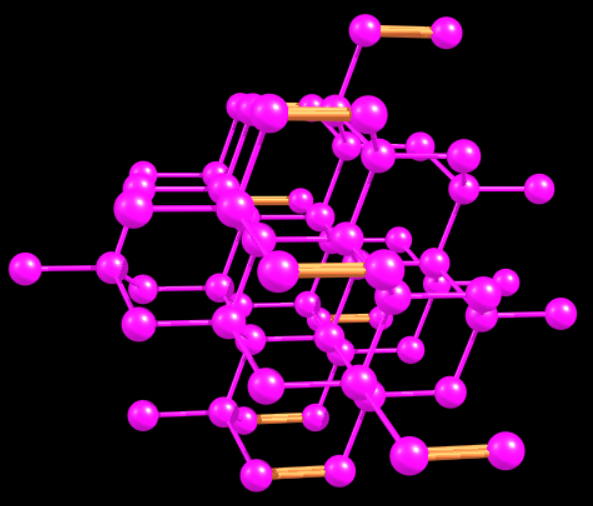

In [32]:
dm.output_txt_coords(filename=None, show_atom_number=False) # Output coords as 'C64.txt' in not_gamess_data/output_coords

In [33]:
dm.get_pd_coords(show_atom_number=False) # pandas DataFrame

,Elem,x,y,z
0,C,0.00000,0.00000,0.00000
1,C,0.89175,0.89175,0.89175
2,C,1.78350,1.78350,0.00000
3,C,2.67525,2.67525,0.89175
4,C,1.78350,0.00000,1.78350
...,...,...,...,...
59,C,6.24225,6.24225,4.45875
60,C,5.35050,3.56700,5.35050
61,C,3.56700,5.35050,5.35050
62,C,6.24225,4.45875,6.24225


### Silicon

In [43]:
sc = DiamondStructure(shape=(2,2,2), struct_name='silicon')

In [45]:
pot_before_relax = sc.calc_pot(sc.struct)/sc.length

In [46]:
sc.relax(iterations=10, TOL=0.01, start_alpha=5e-3, end_alpha=1e-3)

Iteration: 0, alpha: 0.005
AVG Force Before step:  0.02639704211766973

Iteration: 1, alpha: 0.004256699612603923
AVG Force Before step:  0.024612759353839858

Iteration: 2, alpha: 0.003623898318388478
AVG Force Before step:  0.023344092052793544

Iteration: 3, alpha: 0.003085169313600048
AVG Force Before step:  0.02240503011091422

Iteration: 4, alpha: 0.002626527804403767
AVG Force Before step:  0.021696999876916756

Iteration: 5, alpha: 0.00223606797749979
AVG Force Before step:  0.021104186716532827

Iteration: 6, alpha: 0.0019036539387158786
AVG Force Before step:  0.02063506152076628

Iteration: 7, alpha: 0.0016206565966927623
AVG Force Before step:  0.020259362024895672

Iteration: 8, alpha: 0.001379729661461215
AVG Force Before step:  0.019955468419530564

Iteration: 9, alpha: 0.001174618943088019
AVG Force Before step:  0.019707657179617658



In [50]:
pot_after_relax = sc.calc_pot(sc.struct)/sc.length
print(f'SW potential before relaxation: {pot_before_relax}, after: {pot_after_relax}')
print(f'Difference: {round((pot_before_relax-pot_after_relax)/pot_before_relax*100, 4)}%')

SW potential before relaxation: -2.913493295739339, after: -2.9135074152769525
Difference: -0.0005%


# FullereneStructure

## Fullerene class definition

In [51]:
class Fullerene(StillingerWeber, Atoms):
    
    def __set_name_and_number(self) -> None:
        """
        Function set name of atom and number
        """
        self.atom_name = 'C'
        self.atom_num = 6
    
    @staticmethod
    def __extract_coords(filepath='C20.out'):
        """
        Method extracts final coordinates and energy from file after
        relaxations in GAMESS and returns tuple with string divided by '\n' for every
        atom and energy value
        """
        with open(filepath, 'r') as f:
            file = f.read()
        if len(file):
            start = file.find('***** EQUILIBRIUM GEOMETRY LOCATED *****')
            if start == -1:
                raise ValueError('Algorithm has not converged')
            splitted = file[start:].split('\n')
        filename = filepath.split('/')[-1][:-4]
        if '-' in filename:
            n_atoms = int(filename[1: filename.find('-')])
        else:
            n_atoms = int(filename[1:])
        coords = '\n'.join(splitted[4:n_atoms+4])
        energy_idx = file[start:].find('TOTAL ENERGY')
        energy = float(file[start:][energy_idx : file[start:].find('\n', energy_idx)].split(' ')[-1])
        return coords, energy
        
    def __build_struct(self, filepath='coords.txt', skiprows=2, file_from='web', 
                struct_type='numpy'):
        """
        Method builds structure of fullerene. First case - file from website,
        Second case - file from GAMESS output file.
        
            :param filepath: path to file with coordinates (or with output from GAMESS)
            :param skiprows: define how much rows needed to be skipped in parsing file from web
            :param file_from: 'web' or 'gamess_out_file'
            :param struct_type: 'numpy' or 'list'
        """
        coordinates = []
        if file_from == 'web':
            with open(filepath, 'r') as f:
                j = 0
                for row in f:
                    if j >= skiprows:
                        items = [item.strip() for item in row.split(' ') if item.strip()]
                        coordinates += [items[1:4]]
                    j += 1
                    
        elif file_from == 'gamess_out_file':
            string_coords, energy = self.__extract_coords(filepath)
            self.energy = energy            
            j = 0
            for row in string_coords.split('\n'):
                items = [item.strip() for item in row.split(' ') if item.strip() and item.strip() != '6.0']
                coordinates += [items[1:4]]
                j += 1
                
        coordinates = [[float(coord) for coord in item] for item in coordinates]
        
        if struct_type == 'numpy':
            self.struct = np.array(coordinates)
        elif struct_type == 'list':
            self.struct = coordinates
    
    def gen_input_by_template(self, output_path='data.txt', 
                              template_path='gamess_data/templates/default.inp') -> None:
        """
        Method fill coordinates in template and creates input file for GAMESS
        
            :param output_path: path to result of generating file by the template
            :param template_path: path to template to fill in
        """
        
        with open(template_path, 'r') as f:
            template = f.read()
        
        if not len(template):
            raise OSError('template file is empty')
        
        coords = ''
        for i in range(len(self.struct)):
            coords += self.atom_name + '\t' + str(float(self.atom_num)) + '\t' \
                + str(self.struct[i][0]) + '\t' + str(self.struct[i][1]) \
                + '\t' + str(self.struct[i][2]) + '\n'
        
        splitted_text = template.split('\n')
        title = splitted_text[-3].replace('C20', self.atom_name + str(int(len(self.struct))))
        new_text = '\n'.join(splitted_text[:-3]) + '\n' + title + '\n' + 'C1' + '\n' + coords + splitted_text[-1] 
        
        with open(output_path, 'w') as out:
            out.write(new_text)
    
    def __init__(self, filepath='coords.txt', skiprows=2, file_from='web', 
                struct_type='numpy'):
        """
            :param file_from: 
                'web' - create structure from downloaded coords,
                'gamess_out_file' - create structure from output of GAMESS
            :param filepath: path of the file with coordinates
            :param skiprows: is used when file_from == 'web', because it is needed to skip
                some rows (name or something like this) to create correct coords
        """
        super().__init__(struct_name='fullerene') # Initialize SW potential for fullerene
        self.__set_name_and_number()
        self.__build_struct(filepath=filepath, skiprows=skiprows, file_from=file_from, 
                struct_type=struct_type)
            
        self.length = len(self.struct)

## Examples of usage

### Creating fullerene

In [74]:
fln1 = Fullerene(filepath='not_gamess_data/web_coordinates/C36-C2-1.xyz', skiprows=2, file_from='web', struct_type='numpy')
fln2 = Fullerene(filepath='gamess_data/output_data/C36-C2-1.out', file_from='gamess_out_file')

In [83]:
old_energy1 = fln1.calc_pot(fln1.struct)
old_energy2 = fln2.calc_pot(fln2.struct)
print('Web data energy with SW pot: ', fln1.calc_pot(fln1.struct))
print('GAMESS data energy with SW pot: ', fln2.calc_pot(fln2.struct))
print('GAMESS data energy: ', fln2.energy)

Web data energy with SW pot:  -142.32819066712304
GAMESS data energy with SW pot:  -156.5355715667391
GAMESS data energy:  -155.5365615254


### Optimizing params with fullerene

In [84]:
old_params = fln2.params
fln2.optimize_params_for_fullerene(X=np.array([fln2.struct]), y=np.array([fln2.energy]), iterations=10, TOL=8e2)


ITERATION:  0
GRADIENT:  1173.2008521702846
PARAMS VECTOR:  [ 2.16376271  7.05471636  0.21584245  1.70666882  3.9651871   1.67952818
 20.997803    1.36300948 -0.26969633]
TIME TAKEN:  1.561 s

ITERATION:  1
GRADIENT:  1092.2433888112566
PARAMS VECTOR:  [ 2.16374826  7.05471115  0.2159414   1.70668293  3.9651905   1.67947377
 20.99780326  1.36298574 -0.26969477]
TIME TAKEN:  1.529 s

ITERATION:  2
GRADIENT:  1016.8832116486418
PARAMS VECTOR:  [ 2.1637348   7.05470631  0.21603352  1.70669609  3.96519366  1.67942312
 20.9978035   1.36296365 -0.26969331]
TIME TAKEN:  1.556 s

ITERATION:  3
GRADIENT:  946.7344004277662
PARAMS VECTOR:  [ 2.16372228  7.0547018   0.21611929  1.70670835  3.96519661  1.67937596
 20.99780373  1.36294309 -0.26969195]
TIME TAKEN:  1.525 s

ITERATION:  4
GRADIENT:  881.4339946284471
PARAMS VECTOR:  [ 2.16371063  7.0546976   0.21619913  1.70671979  3.96519935  1.67933205
 20.99780394  1.36292395 -0.26969068]
TIME TAKEN:  1.502 s

ITERATION:  5
GRADIENT:  820.6443645

In [85]:
new_energy1 = fln1.calc_pot(fln1.struct)
new_energy2 = fln2.calc_pot(fln2.struct)

In [87]:
print('Web data energy with SW pot before: ', round(old_energy1, 4), ' after: ', round(new_energy1,4))
print('GAMESS data energy with SW pot before: ', round(old_energy2, 2), ' after: ',  round(new_energy2,2))
print('GAMESS data energy: ', fln2.energy)
print('Change in parameters: ', old_params - fln2.params)

Web data energy with SW pot before:  -142.3282  after:  -142.3282
GAMESS data energy with SW pot before:  -156.54  after:  -156.14
GAMESS data energy:  -155.5365615254
Change in parameters:  [ 8.24125930e-05  2.96818786e-05 -5.64682718e-04 -8.08190105e-05
 -1.94111561e-05  3.10503797e-04 -1.47990037e-06  1.35325388e-04
 -8.97160679e-06]


# Gamess class

In [28]:
class Gamess:
    """
        Class for preparing inputs for GAMESS and running the GAMESS
    """
    def generate_all_inputs(self, dir_path='gamess_data/inputs',
                            template_path='gamess_data/templates/default.inp',
                            web_coords_path='not_gamess_data/web_coordinates'):
        """
            Method generates inputs for GAMESS for all files in folder dir_path 
            (with template from template_path)
        """
        
        fln_files = os.listdir(web_coords_path)
        for file in fln_files:
            fln = Fullerene(web_coords_path + file, file_from='web')
            fln.gen_input_by_template(output_path=os.path.join(dir_path, file[:-4] +'.inp'), template_path=template_path)
                                       
    def run_gamess(self, gamess_path='C:\\Users\Public\gamess-64'):
        """
            Method runs GAMESS program
        """
        initial_dir = os.getcwd()
        try:
            os.chdir(gamess_path)
            input_files = os.listdir('inputs')
            for inp in input_files:
                print('running ', inp)
                if inp != 'README.txt':
                    os.system('rungms.bat ' + os.path.join('inputs', inp) + ' 2022.R2.intel 2 ' \
                          + os.path.join('outputs', inp[:-4]) + '.out')
        except Exception as e:
            print('Something went wrong')
            print(e)
        finally:
            os.chdir(initial_dir)

## Examples of usage

In [9]:
gm = Gamess()
gm.generate_all_inputs()
gm.run_gamess()

running  C36-C2-1.inp
running  C36-C2-11.inp
running  C36-D3h-13.inp
running  C40-C2-18.inp
running  C40-C3v-20.inp
running  C40-D2-3.inp
running  C40-D5d-1.inp
running  C44-C2-1.inp
running  C44-C2-12.inp
running  C44-C2-20.inp
running  C48-C1-21.inp
running  C48-C2-1.inp
running  C52-C2-1.inp
running  C52-C2-5.inp
running  C70-D5h.inp
running  C76-D2.inp
running  README.txt
time: 1min 38s (started: 2023-05-27 21:09:54 +03:00)


# Some other results

## Fullerene parameters for SW potential for Diamond structure

In [36]:
df = pd.DataFrame({
    'config': ['' for i in range(8)],
    'pot': [0 for i in range(8)],
    'atom_pot': [0 for i in range(8)],
})
for i in range(8):
    sc = DiamondStructure(shape=(i, i, i), struct_name='diamond')
    pot_sc = sc.calc_pot(sc.struct)
    df.loc[i, 'config'] = f'{i}x{i},{i}'
    df.loc[i, 'pot'] = pot_sc
    df.loc[i, 'atom_pot'] = pot_sc/sc.length
    print(f'Shape: ({i},{i},{i}) ', round(pot_sc, 2), round(pot_sc/sc.length, 2))

Shape: (0,0,0)  -20.92 -2.61
Shape: (1,1,1)  -20.92 -2.61
Shape: (2,2,2)  -261.07 -4.08
Shape: (3,3,3)  -1013.66 -4.69
Shape: (4,4,4)  -2571.74 -5.02
Shape: (5,5,5)  -5228.4 -5.23
Shape: (6,6,6)  -9276.69 -5.37
Shape: (7,7,7)  -15009.69 -5.47
time: 27min 38s (started: 2023-05-28 00:13:38 +03:00)


In [37]:
df.to_excel('other_data/diamond.xlsx', index=False)

time: 1.61 s (started: 2023-05-28 00:42:53 +03:00)


## Comparision between GAMESS and SW

In [88]:
X = []
y = []
dir_list = os.listdir('gamess_data/output_data/')
for file in dir_list:
    fln = Fullerene(filepath='gamess_data/output_data/' + file, file_from='gamess_out_file',
                   struct_type='numpy')
    X += [fln.struct]
    y += [fln.energy]

data = pd.DataFrame({
    'config': ['' for i in range(len(X))],
    'gamess_potential': [0 for i in range(len(X))],
    'stillinger_potential': [0 for i in range(len(X))],
    'gamess_potential_atom': [0 for i in range(len(X))],
    'stillinger_potential_atom': [0 for i in range(len(X))],
    'error': [0 for i in range(len(X))]
})
for i in range(len(X)):
    pot = fln.calc_pot(X[i])
    data.loc[i, 'config'] = dir_list[i][:-4]
    data.loc[i, 'gamess_potential'] = y[i]
    data.loc[i, 'stillinger_potential_atom'] = pot/len(X[i])
    data.loc[i, 'gamess_potential_atom'] = pot/len(X[i])
    data.loc[i, 'stillinger_potential'] = y[i]
    data.loc[i, 'error'] = (round((y[i] - pot)/y[i] * 100, 1))
    data.loc[i, 'abs_error'] = abs(data.loc[i, 'error'])
    print(pot, y[i], '%: ', round((y[i] - pot)/y[i] * 100, 1))

-409.46697267548956 -434.2547783745 %:  5.7
-108.38924185800283 -103.4005536286 %:  -4.8
-116.25465504205464 -112.0853372183 %:  -3.7
-124.27881630753105 -120.7858857245 %:  -2.9
-123.84028235404485 -120.7943822015 %:  -2.5
-132.15049552746444 -129.4907296771 %:  -2.1
-131.64777265962078 -129.5145620236 %:  -1.6
-133.52842381950788 -129.4129122439 %:  -3.2
-140.3869479974244 -138.1689078749 %:  -1.6
-139.78145580499302 -138.1987903156 %:  -1.1
-140.80058150384357 -138.1503482644 %:  -1.9
-139.6758534264674 -138.2373639969 %:  -1.0
-141.07751203072243 -138.1322308911 %:  -2.1
-140.07759696563147 -138.1226078183 %:  -1.4
-156.5355715667391 -155.5365615254 %:  -0.6
-155.78792282929908 -155.6070235424 %:  -0.1
-156.25255542062666 -155.5557745786 %:  -0.4
-171.71160933530592 -172.9194882173 %:  0.7
-171.74659090506307 -172.9505557709 %:  0.7
-174.39801846792216 -172.7911417407 %:  -0.9
-175.6425712264899 -172.7381115961 %:  -1.7
-189.67344086397097 -190.2198710739 %:  0.3
-188.4973671634111

In [32]:
data.to_excel('other_data/data.xlsx', index=False)

time: 63 ms (started: 2023-05-27 23:10:14 +03:00)
